## Description
For the model from Q1, use the TFLiteConverter to
convert your trained model into a TensorFlow Lite model, and save it as a “s_mnist.tflite” file. Then perform post
training dynamic quantization, and save the resulting file as “s_mnist_quant_dyn.tflite”. Determine the accuracy of
both models on the test set, and comment on the model sizes of the files. Include your notebook and tflite files.

In [15]:
import pandas as pd
import numpy as np
import os
import scipy
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model

#tf version should be 2.5 or higher
tf.__version__

'2.10.1'

In [16]:
# check if GPU is being used
print("GPU Status: ", end = '')
if len(tf.config.list_physical_devices('GPU')) != 0: print("Active")
else: print("Inactive")

GPU Status: Active


In [17]:
# get dataset
train_dir = os.path.join('C:\\Users\\ptpsm\\.keras\\datasets', 'sign_mnist_train','sign_mnist_train.csv')
test_dir = os.path.join('C:\\Users\\ptpsm\\.keras\\datasets', 'sign_mnist_test','sign_mnist_test.csv')

train_file = tf.keras.utils.get_file('sign_mnist_train.csv', train_dir)
test_file = tf.keras.utils.get_file('sign_mnist_test.csv', test_dir)

train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)

In [18]:
# Display the shape of the training data
train_df.shape

(27455, 785)

In [19]:
# Display the first 5 rows of the training data
train_df.head()

label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      3     107     118     127     134     139     143     146     150   
1      6     155     157     156     156     156     157     156     158   
2      2     187     188     188     187     187     186     187     188   
3      2     211     211     212     212     211     210     211     210   
4     13     164     167     170     172     176     179     180     184   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0     153  ...       207       207       207       207       206       206   
1     158  ...        69       149       128        87        94       163   
2     187  ...       202       201       200       199       198       199   
3     210  ...       235       234       233       231       230       226   
4     185  ...        92       105       105       108       133       163   

   pixel781  pixel782  pixel783  pixel784  
0       206       204       203       202  
1       175       103       135       149  
2       198       195       194       195  
3       225       222       229       163  
4       157       163       164       179  

[5 rows x 785 columns]

In [20]:
# Extract the labels from the training and test data
y_train=train_df['label']
y_test=test_df['label']
train_df.drop('label',axis=1,inplace=True)
test_df.drop('label',axis=1,inplace=True)

In [21]:
# Display the shape of the training data after dropping the label column
train_df.shape

(27455, 784)

In [22]:
from sklearn.preprocessing import LabelBinarizer
# Convert the labels to binary representation
label_binarizer = LabelBinarizer()
Y = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)

In [23]:
# Convert the training and test data to numpy arrays and normalize the pixel values
x_train=train_df.values
x_test=test_df.values
x_train=x_train/255
x_test=x_test/255
X = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

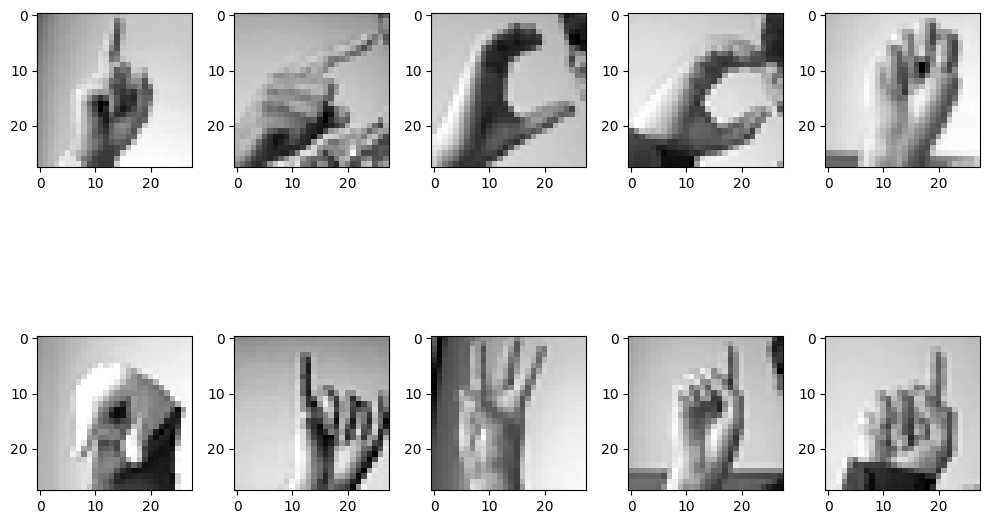

In [24]:
# Display a sample of the training images using matplotlib
f, ax = plt.subplots(2,5) 
f.set_size_inches(10, 10)
k = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(X[k].reshape(28, 28) , cmap = "gray")
        k += 1
    plt.tight_layout() 

In [25]:
# Split the training data into training and validation sets

x_train,x_val,y_train,y_val=train_test_split(X,Y,test_size=0.2,random_state=42)

In [26]:
# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
                             ) 


datagen.fit(x_train)
train_data=datagen.flow(x_train,y_train, batch_size = 128)

In [27]:
model_file = '/kaggle/input/model/sign_language_classification (2).h5'

if os.path.exists(model_file):
    # Load the pre-trained model if it exists
    model=load_model(model_file)
    
else: 
    
    # Define the model architecture
    model = Sequential()
    model.add(Conv2D(75 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (28,28,1)))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Conv2D(50 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Conv2D(25 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Flatten())
    model.add(Dense(units = 512 , activation = 'relu'))
    model.add(Dropout(0.3))
    model.add(Dense(units = 24 , activation = 'softmax'))
    # Compile the model
    model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

In [28]:
# Train the model
history = model.fit(train_data, epochs = 30 , validation_data = (x_val, y_val))

Epoch 1/30
172/172 [==============================] - 3s 16ms/step - loss: 1.1854 - accuracy: 0.6288 - val_loss: 3.9953 - val_accuracy: 0.1118
Epoch 2/30
172/172 [==============================] - 3s 15ms/step - loss: 0.2908 - accuracy: 0.9019 - val_loss: 2.8845 - val_accuracy: 0.2504
Epoch 3/30
172/172 [==============================] - 2s 14ms/step - loss: 0.1394 - accuracy: 0.9552 - val_loss: 0.4507 - val_accuracy: 0.8539
Epoch 4/30
172/172 [==============================] - 2s 14ms/step - loss: 0.0895 - accuracy: 0.9711 - val_loss: 0.0429 - val_accuracy: 0.9914
Epoch 5/30
172/172 [==============================] - 2s 14ms/step - loss: 0.0580 - accuracy: 0.9827 - val_loss: 0.0510 - val_accuracy: 0.9854
Epoch 6/30
172/172 [==============================] - 3s 15ms/step - loss: 0.0499 - accuracy: 0.9838 - val_loss: 0.0069 - val_accuracy: 0.9991
Epoch 7/30
172/172 [==============================] - 3s 15ms/step - loss: 0.0422 - accuracy: 0.9856 - val_loss: 0.0542 - val_accuracy: 0.9832

In [29]:
def eval_model(interpreter_name, interpreter):
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    # Run predications on every image in the "test" dataset.
    # print(interpreter_name)
    predication_images = []
    for i, test_image in enumerate(x_test):
        # if i % 1000 == 0:
        #     print('Evaluated on {n} results so far.'.format(n=i))
        # Pre-procession: add batch dimension and convert to float32 to match with
        # the model's input data format.
        test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
        interpreter.set_tensor(input_index, test_image)

        # Run inference
        interpreter.invoke()

        # Post-processing: remove batch dimension and find the digit with highest
        # probability.
        output = interpreter.tensor(output_index)
        image = np.argmax(output()[0])
        predication_images.append(image)

    print('\n')
    # Compare predication results with ground truth labels to calculate accuracy.
    predication_images = np.array(predication_images)
    y_test_arr = []
    for i, test_label in enumerate(y_test):
        for j in range(len(test_label)):
            if test_label[j] == 1: y_test_arr.append(j)

    accuracy = (predication_images == y_test_arr).mean()
    return accuracy

In [30]:
# Save TFLite models
# No Optimization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model_NOopt = converter.convert()
with open('s_mnist.tflite', 'wb') as f:
  f.write(tflite_model_NOopt)


# Dynamic Optimization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model_DYNopt = converter.convert()
with open('s_mnist_quant_dyn.tflite', 'wb') as f:
  f.write(tflite_model_DYNopt)

INFO:tensorflow:Assets written to: C:\Users\ptpsm\AppData\Local\Temp\tmpewj96f4t\assets


INFO:tensorflow:Assets written to: C:\Users\ptpsm\AppData\Local\Temp\tmpewj96f4t\assets


INFO:tensorflow:Assets written to: C:\Users\ptpsm\AppData\Local\Temp\tmpfkkqwdkg\assets


INFO:tensorflow:Assets written to: C:\Users\ptpsm\AppData\Local\Temp\tmpfkkqwdkg\assets


In [31]:
# Evaluate TFLite Models
NOopt_interpreter = tf.lite.Interpreter(model_content=tflite_model_NOopt)
NOopt_interpreter.allocate_tensors()

DYNopt_interpreter = tf.lite.Interpreter(model_content=tflite_model_DYNopt)
DYNopt_interpreter.allocate_tensors()

NOopt_accuracy = eval_model('s_mnist.tflite', NOopt_interpreter)
DYNopt_accuracy = eval_model('s_mnist_quant_dyn.tflite', DYNopt_interpreter)
print('No Optimization TFLite Accuracy: ', NOopt_accuracy)
print('Dynamic Optimization TFLite Accuracy: ', DYNopt_accuracy)





No Optimization TFLite Accuracy:  0.9863357501394311
Dynamic Optimization TFLite Accuracy:  0.9861963190184049


s_mnist.tflite Size: 1.01 MB \
s_mnist_quant_dyn.tflite Size: 272 KB